In [1]:
import os
import sys
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models import vanilla_autoencoder


import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

pd.options.display.width = 1000


# Silhouette score of original groups
from sklearn.metrics import silhouette_score
from utils.benchmark import dunn_index
from utils.benchmark import davies_bouldin

from sklearn.cluster import KMeans

import helpers


%load_ext tensorboard
!rm -rf ../workfiles/logs/

## Experiment 

In [87]:
suggested_genes_file_1 = '../../data/PD_genes_of_interest/signif_de_Disease_status_IDIOPATHIC_PD_01.tsv'
suggested_genes_file_2 = '../../data/PD_genes_of_interest/signif_de_PD_DIAGNOSIS_0.1.tsv'

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  5 ...
min MAD 0.0
max MAD 4194.0


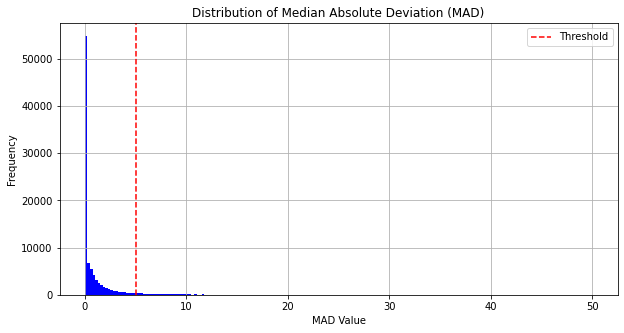

removing 89395 genes under the MAD threshold from the dataset
number of genes selected :  5914
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [2]:
# experiment 1
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 5, 
    gene_selection_file = None)

In [88]:
# experiment 2
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_1)

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...


not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 2225.368


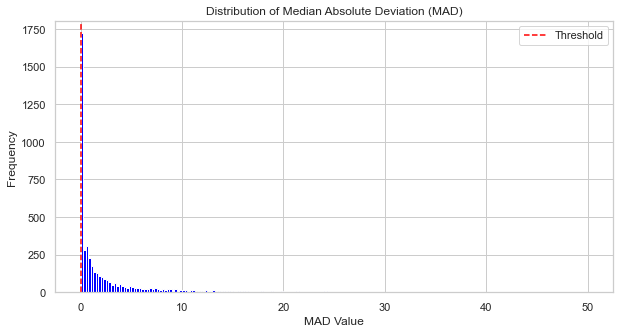

removing 1562 genes under the MAD threshold from the dataset
number of genes selected :  3283
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [41]:
# experiment 3
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_2)


## End of experiment selection

In [3]:
importlib.reload(vanilla_autoencoder) # to allow modification of the script without restarting the whole session

latent_dim = 32

t_shape = (n_genes)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [4]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=20, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=70)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [5]:
hist = autoencoder.fit(x_train, epochs=700, callbacks=cb) # around 16 hours for transcripts dataset 

Epoch 1/700


2023-09-18 13:51:02.955012: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


70/70 [==============================] - 9s 109ms/step - loss: 0.0229 - lr: 0.0010
Epoch 2/700
70/70 [==============================] - 7s 99ms/step - loss: 0.0154 - lr: 0.0010
Epoch 3/700
70/70 [==============================] - 7s 93ms/step - loss: 0.0163 - lr: 0.0010
Epoch 4/700
70/70 [==============================] - 7s 100ms/step - loss: 0.0150 - lr: 0.0010
Epoch 5/700
70/70 [==============================] - 6s 85ms/step - loss: 0.0137 - lr: 0.0010
Epoch 6/700
70/70 [==============================] - 6s 86ms/step - loss: 0.0116 - lr: 0.0010
Epoch 7/700
70/70 [==============================] - 6s 82ms/step - loss: 0.0117 - lr: 0.0010
Epoch 8/700
70/70 [==============================] - 6s 85ms/step - loss: 0.0115 - lr: 0.0010
Epoch 9/700
70/70 [==============================] - 6s 88ms/step - loss: 0.0114 - lr: 0.0010
Epoch 10/700
70/70 [==============================] - 6s 90ms/step - loss: 0.0111 - lr: 0.0010
Epoch 11/700
70/70 [==============================] - 6s 89ms/step - 

In [6]:
autoencoder.load_weights(checkpoint_filepath)


benchmarking model : vanilla_autoencoder
number of parametters of the model: 13442624
shape of the dataset: (4445, 5914)
the dataset meets the min_max requirement
loss: 0.0048805927
adding new performer to the history


,model_name,param_count,loss,obs_count,gene_number
0,FC_autoencoder,50460224,0.008361,4445,23989
1,FC_autoencoder,50460224,0.008114,4445,23989
2,vanilla_autoencoder,19887680,0.019203,4445,9061
3,vanilla_autoencoder,5805632,0.002761,4445,2185
4,vanilla_autoencoder,13442624,0.004807,4445,5914
5,vanilla_autoencoder,5805632,0.003180,4445,2185
6,vanilla_autoencoder,8054336,0.009517,4445,3283
7,vanilla_autoencoder,5805632,0.002430,4445,2185
0,vanilla_autoencoder,13442624,0.004881,4445,5914


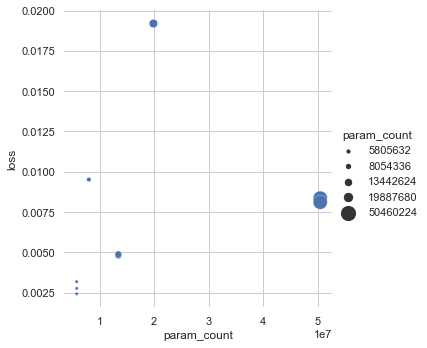

In [7]:
importlib.reload(benchmark) # to allow modification of the script without restarting the whole session
benchmark.benchmark(autoencoder, x_train)

[0.01777426153421402, 0.015471847727894783, 0.01565897837281227, 0.014816471375524998, 0.012870139442384243, 0.011475165374577045, 0.011329093016684055, 0.011133354157209396, 0.010983525775372982, 0.010805084370076656, 0.010710716247558594, 0.010685253888368607, 0.010576806031167507, 0.010425880551338196, 0.010386442765593529, 0.01025299821048975, 0.010062857531011105, 0.010185192339122295, 0.009876878932118416, 0.009764688089489937, 0.009724314324557781, 0.009680597111582756, 0.009653512388467789, 0.009574179537594318, 0.009590789675712585, 0.00952143408358097, 0.00946332048624754, 0.00942188035696745, 0.00931916106492281, 0.009216776117682457, 0.009118116460740566, 0.008947168476879597, 0.008870343677699566, 0.008915840648114681, 0.008798239752650261, 0.008765251375734806, 0.008785956539213657, 0.008708808571100235, 0.008669355884194374, 0.008842194452881813, 0.008667265996336937, 0.00867387279868126, 0.008652223274111748, 0.008647052571177483, 0.008694777265191078, 0.008627851493656

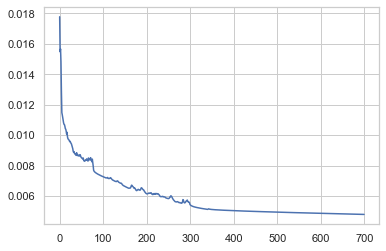

In [8]:
plt.plot(hist.history['loss'])
print(hist.history['loss'])

### some diagnosis

In [9]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_single_obs_processing(x_train, autoencoder)

In [10]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

70/70 [==============================] - 1s 8ms/step


In [12]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

139/139 [==============================] - 1s 5ms/step


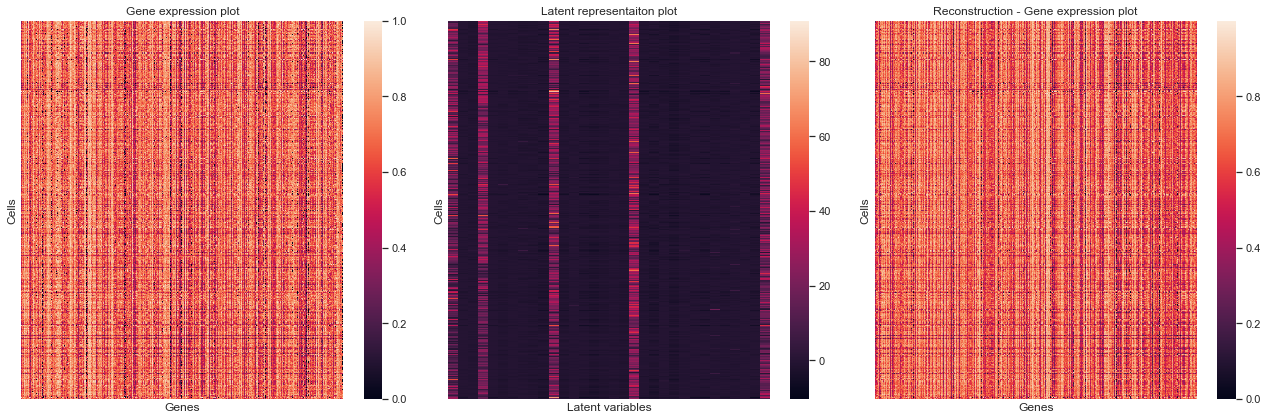

In [11]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_dataset_processing(x_train, autoencoder)

In [14]:
metadata_path = "../../METADATA_200123.xlsx"

meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )
patient_ids = [int(name.split(".")[1]) for name in filenames]

# Create a dictionary to map 'Patient Number' to 'Disease Status'
patient_disease_status = dict(zip(meta_data['Patient Number'], meta_data['Disease Status']))

label = [patient_disease_status.get(patient_id, None) for patient_id in patient_ids]
label = pd.Series(label)
num_classes = len(pd.Series(label).unique())

## First, Analyse All groups

######################## OG Groups : 


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



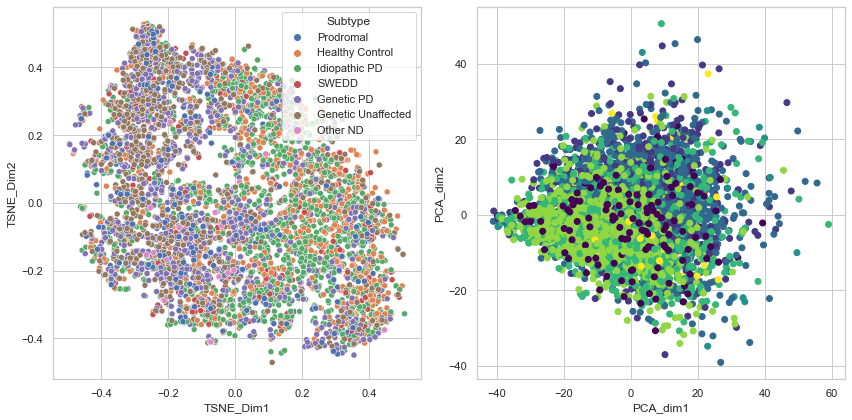

Silhouette Score: -0.0431
Dunn Index: 0.2692
Davies-Bouldin Index: 10.6710
######################## KNMEANS : 


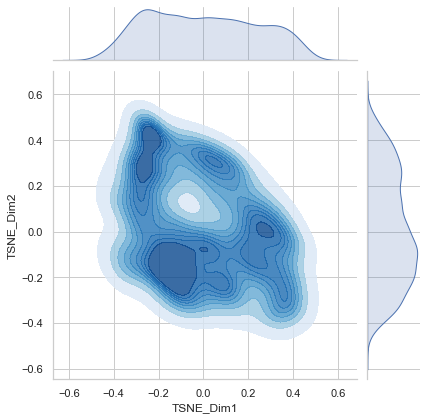

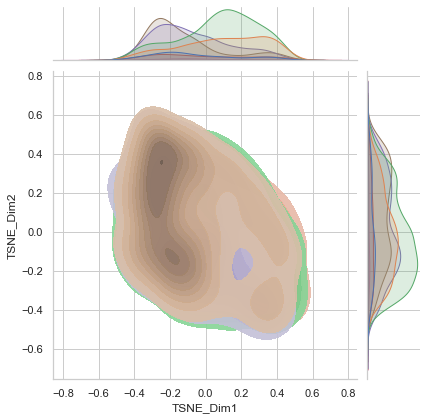

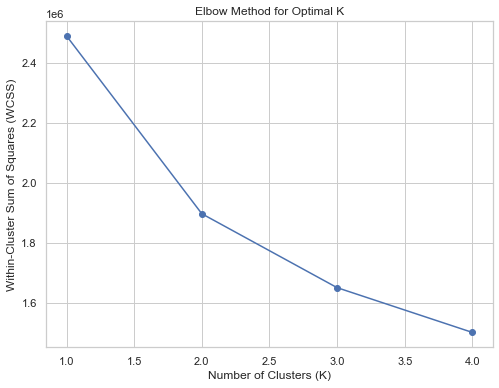

nothing found
######################## DBSCAN : 
Number of clusters: 0
nothing found


In [77]:
importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
TSNE_params = {
            "early_exaggeration" : 50,
            "learning_rate" : 500, 
            #"perplexity" : 75, 
            "perplexity" : 100, 
            "min_grad_norm" : 1e-7, 
            "n_iter" : 2000,
            "n_components" : 2
        }
visualisation.plot_clusters(compressed_dataframe, label, TSNE_params)
benchmark.print_metrics(compressed_dataframe, label)

print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(compressed_dataframe)
if(len(np.unique(kmeans_labels)) == 1):
    print("nothing found")
else:   
    visualisation.plot_clusters(compressed_dataframe, kmeans_labels, TSNE_params)
    benchmark.print_metrics(compressed_dataframe, kmeans_labels)

print("######################## DBSCAN : ")
DBSCAN_labels = helpers.auto_DBSCAN(compressed_dataframe)
if(len(np.unique(DBSCAN_labels)) > 1): 
    benchmark.print_metrics(compressed_dataframe, DBSCAN_labels)
    visualisation.plot_clusters(compressed_dataframe, DBSCAN_labels, TSNE_params)
else :
    print("nothing found")

## Second, Check if control group leads to any clusters 

In [78]:
# filtering data
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
clinical_mask = clinical_info_series == "Healthy Control"


# Apply the mask to your dataset
filtered_dat = compressed_dataframe[clinical_mask]
filtered_clinical_info = clinical_info_series[clinical_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(820, 32)
(820,)


######################## OG Groups : 


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



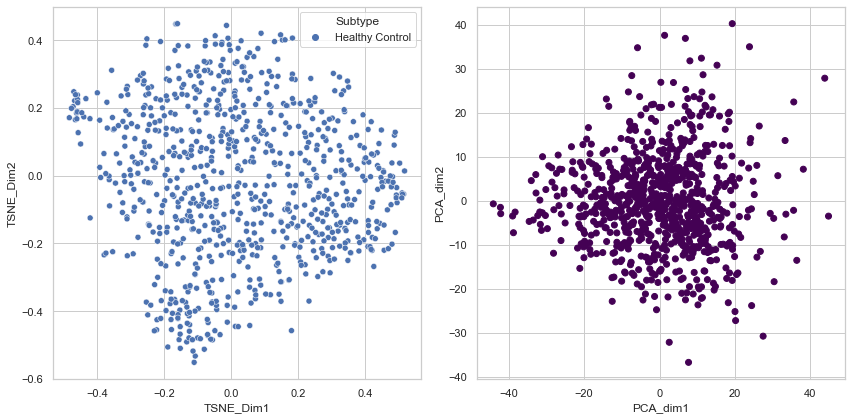

######################## KNMEANS : 


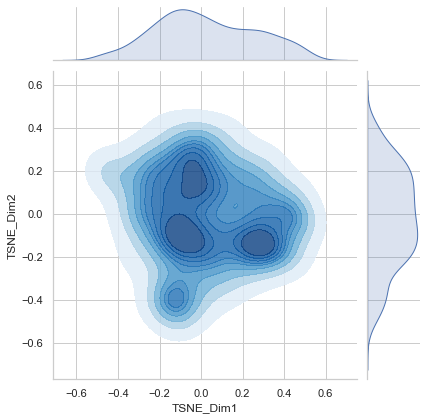

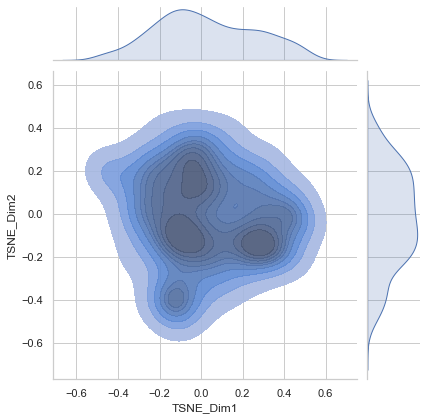

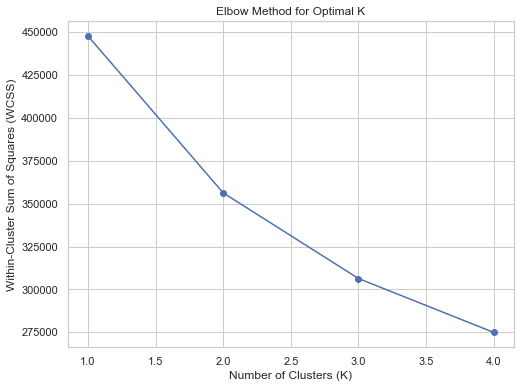

nothing found
######################## DBSCAN : 
Number of clusters: 0
nothing found


In [81]:
importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
TSNE_params = {
            "early_exaggeration" : 50,
            "learning_rate" : 500, 
            "perplexity" : 50, 
            "min_grad_norm" : 1e-7, 
            "n_iter" : 2000,
            "n_components" : 2
        }
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, TSNE_params)

print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(filtered_dat)
if(len(np.unique(kmeans_labels)) == 1):
    print("nothing found")
else:   
    visualisation.plot_clusters(filtered_dat, kmeans_labels, TSNE_params)
    benchmark.print_metrics(filtered_dat, kmeans_labels)

print("######################## DBSCAN : ")
DBSCAN_labels = helpers.auto_DBSCAN(filtered_dat)
if(len(np.unique(DBSCAN_labels)) > 1): 
    benchmark.print_metrics(filtered_dat, DBSCAN_labels)
    visualisation.plot_clusters(filtered_dat, DBSCAN_labels, TSNE_params)
else :
    print("nothing found")

## Third : check for clusters in the Idiopathic PD group

In [84]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
clinical_mask = clinical_info_series == "Idiopathic PD"


# Apply the mask to your dataset
filtered_dat = compressed_dataframe[clinical_mask]
filtered_clinical_info = clinical_info_series[clinical_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(1400, 32)
(1400,)


######################## OG Groups : 


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



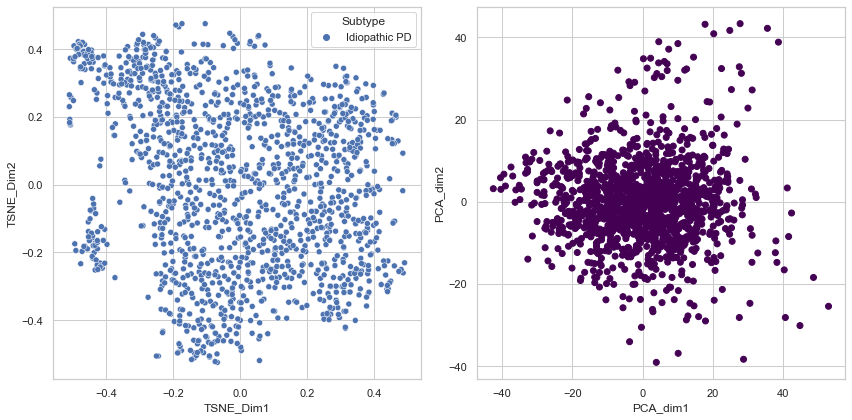

######################## KNMEANS : 


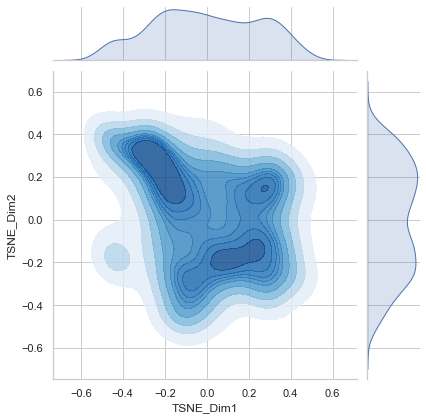

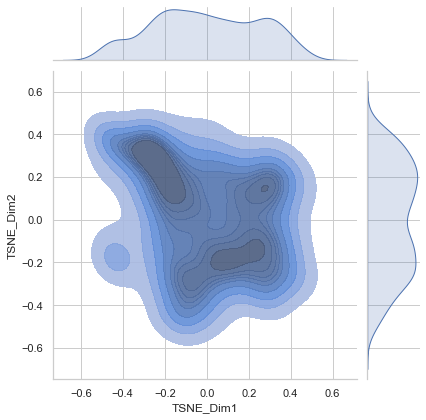

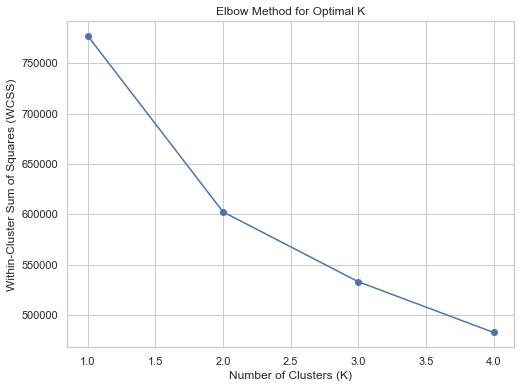

nothing found
######################## DBSCAN : 
Number of clusters: 0
nothing found


In [83]:
importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
params = {"early_exaggeration":10,
              "learning_rate":700, 
              "perplexity":15, 
              "min_grad_norm":1e-7, 
              "n_iter":1000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, TSNE_params)

print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(filtered_dat)
if(len(np.unique(kmeans_labels)) == 1):
    print("nothing found")
else:   
    visualisation.plot_clusters(filtered_dat, kmeans_labels, TSNE_params)
    benchmark.print_metrics(filtered_dat, kmeans_labels)

print("######################## DBSCAN : ")
DBSCAN_labels = helpers.auto_DBSCAN(filtered_dat)
if(len(np.unique(DBSCAN_labels)) > 1): 
    benchmark.print_metrics(filtered_dat, DBSCAN_labels)
    visualisation.plot_clusters(filtered_dat, DBSCAN_labels, TSNE_params)
else :
    print("nothing found")

## Last : Check for Genetic PD groups

In [85]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
clinical_mask = clinical_info_series == "Genetic PD"


# Apply the mask to your dataset
filtered_dat = compressed_dataframe[clinical_mask]
filtered_clinical_info = clinical_info_series[clinical_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(944, 32)
(944,)


######################## OG Groups : 


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



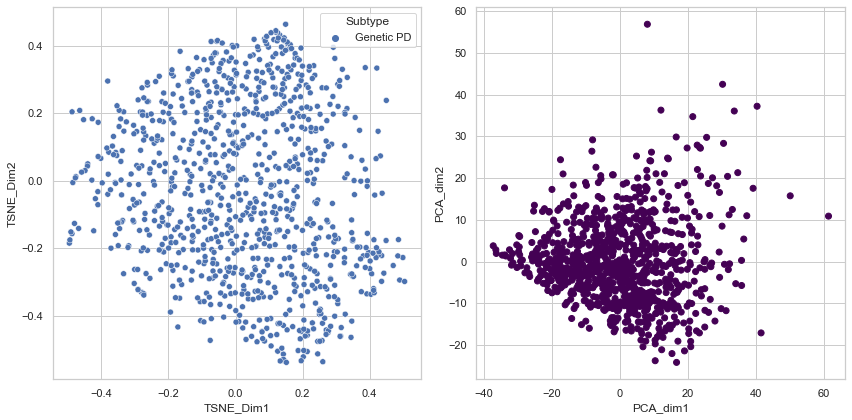

######################## KNMEANS : 


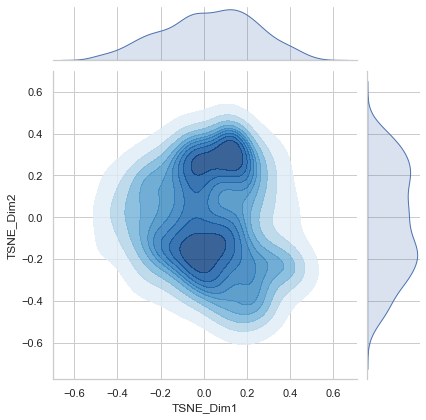

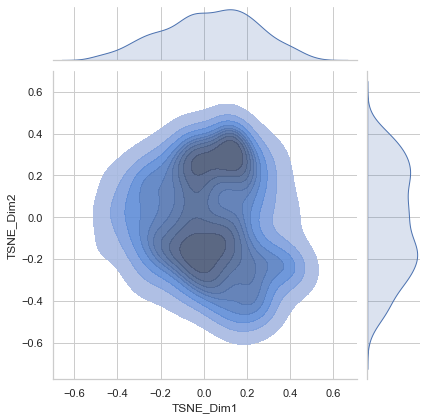

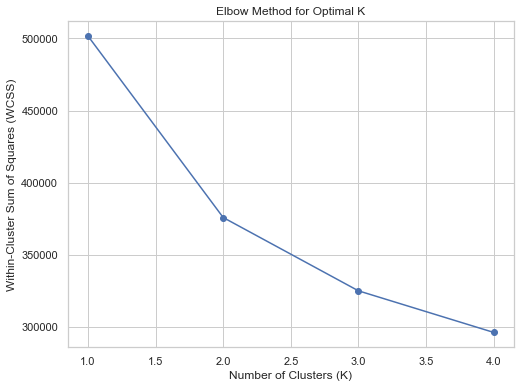

nothing found
######################## DBSCAN : 
Number of clusters: 0
nothing found


In [86]:
importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
params = {"early_exaggeration":5,
              "learning_rate":100, 
              "perplexity":30, 
              "min_grad_norm":1e-7, 
              "n_iter":5000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, TSNE_params)

print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(filtered_dat)
if(len(np.unique(kmeans_labels)) == 1):
    print("nothing found")
else:   
    visualisation.plot_clusters(filtered_dat, kmeans_labels, TSNE_params)
    benchmark.print_metrics(filtered_dat, kmeans_labels)

print("######################## DBSCAN : ")
DBSCAN_labels = helpers.auto_DBSCAN(filtered_dat)
if(len(np.unique(DBSCAN_labels)) > 1): 
    benchmark.print_metrics(filtered_dat, DBSCAN_labels)
    visualisation.plot_clusters(filtered_dat, DBSCAN_labels, TSNE_params)
else :
    print("nothing found")